<a href="https://colab.research.google.com/github/Ciela-Institute/Bayesian_Inference_Tutorial/blob/Ciela_Simulation_Based_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation-Based Inference Tutorial

In this notebook, we will explore fundamental methods of **simulation-based inference** to perform accurate statistical inference in a real-world problem. Specifically, given a noisy image of a **Gaussian blob**, our goal is to **infer the posterior distribution** of its **center position** and **radius (standard deviation)**.

This notebook provides all the necessary functions and can be executed without any additional coding or implementation.

## Objectives

By running this notebook, you will obtain the following results:

- **Sampling the true posterior** using the **analytical likelihood** and **MCMC sampling method**:
  - This method estimates the posterior using the full observed image as input.
  - Since it leverages all available information, it provides the **most precise posterior**.

- **Training a convolutional neural network** (CNN) to **compress the full observed image** into low-dimensional **summary statistics**:
  - This step is commonly used in **simulation-based inference** to improve the tractability and robustness of density estimation.

- **Applying four well-known methods** from the framework of **Simulation-Based Inference (SBI)**:

  1. **Approximate Bayesian Computation (ABC) (With Neural Network Compression)**  
     - Generates **simulated noisy data** from randomly sampled model parameters.
     - Compares the simulated data with the observed data.
     - If the simulated data is sufficiently close to the observed data, we retain the model parameter as a sample from the posterior.

  2. **Amortized Posterior Inference (With Neural Network Compression)**  
     - We generate training data consisting of **model parameters** and **compressed data** obtained using the CNN-based compressor.
     - A mapping is learned from compressed data to the **posterior distribution** of model parameters.

  3. **Amortized Likelihood Inference (With Neural Network Compression)**  
     - We generate training data consisting of **model parameters** and **compressed data** using the CNN-based compressor.
     - A mapping is learned from **model parameters** to the **likelihood distribution** of the compressed data.
     - Inference is performed by combining the learned likelihood with a **prior** to obtain the **posterior distribution**.

  4. **Amortized Posterior Inference (Without Compression)**  
     - A convolutional neural network is trained **directly** to map the **observed image** to the posterior distribution of model parameters.
     - Since this method utilizes the **full information content** of the observed data, it should be **consistent with the analytical posterior** obtained earlier using the full analytical likelihood.

---

This notebook will guide you through implementing and comparing these approaches, providing insights into **simulation-based inference techniques** for real-world applications.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

!pip install emcee corner --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner

from torch.distributions.multivariate_normal import MultivariateNormal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.6 MB/s eta 0:00:00


## Forward Model, Prior, and Observational Noise

We define the forward model, implement functions to sample from the prior, and generate simulated data observations given model parameters.


### Forward Model
The forward model generates a 2D Gaussian blob given the parameters:
- **Inputs**: $x_0, y_0$ (center position) and $\sigma$ (standard deviation of the Gaussian blob).
- **Output**: A 2D image where the intensity follows:
  $$
  \exp\left( -\frac{(X - x_0)^2 + (Y - y_0)^2}{2 \sigma^2} \right)
  $$

### Prior Distribution
The parameters are sampled from uniform distributions:
- $$ x_0, y_0 \sim U(-1, 1) $$
- $$ \sigma \sim U(0.05, 0.5) $$

### Observational Noise
Gaussian noise is added to the generated images:
- Noise sampled from $N(0, \sigma_{\text{noise}}^2)$, where $\sigma_{\text{noise}}$ is a predefined standard deviation.

In [2]:

def forward_model(params, image_size=16):
    """
    Differentiable and batchable 2D Gaussian blob in PyTorch.

    params:  (..., 3) shape tensor where the last dimension is [x0, y0, sigma]
             This can be a single sample shape [3] or a batch shape [B, 3].

    image_size: Output image size (square grid).

    Returns:
        A torch.Tensor of shape (..., image_size, image_size),
        where each [x0, y0, sigma] produces one 2D Gaussian blob:
            exp( -((X - x0)^2 + (Y - y0)^2) / (2 * sigma^2) ).
    """
    # Ensure params has a batch dimension
    if params.ndim == 1:
        params = params.unsqueeze(0)  # shape -> [1, 3]

    x0 = params[..., 0]  # shape [B]
    y0 = params[..., 1]  # shape [B]
    s  = params[..., 2]  # shape [B]

    # Create a coordinate grid from -1 to 1
    xs = torch.linspace(-1, 1, steps=image_size, device=params.device, dtype=params.dtype)
    ys = torch.linspace(-1, 1, steps=image_size, device=params.device, dtype=params.dtype)
    grid_x, grid_y = torch.meshgrid(xs, ys, indexing='ij')  # shape [image_size, image_size]

    # Expand grid to match batch dimension [B, image_size, image_size]
    # by unsqueezing and then broadcasting
    grid_x = grid_x.unsqueeze(0)  # [1, image_size, image_size]
    grid_y = grid_y.unsqueeze(0)  # [1, image_size, image_size]

    # x0, y0, s each shape [B], so unsqueeze them to [B, 1, 1] for broadcasting
    x0 = x0.view(-1, 1, 1)
    y0 = y0.view(-1, 1, 1)
    s  = s.view(-1, 1, 1)

    # Compute 2D Gaussian
    gauss = torch.exp(-((grid_x - x0)**2 + (grid_y - y0)**2) / (2.0 * s**2))
    gauss = gauss.view(gauss.size(0), -1)  # Flatten to [B, -1]
    max_vals = torch.max(gauss, dim=1, keepdim=True)[0]  # Take max along the flattened dimension
    max_vals = max_vals.view(-1, 1, 1)  # Reshape to [B, 1, 1, 1]
    gauss = gauss.view(params.size(0), image_size, image_size)  # Reshape back to [B, H, W]
    gauss /= max_vals  # Normalize by max value

    return gauss  # shape [B, image_size, image_size] if B>1, else [1, H, W]


def sample_prior(num_samples):
    """
    Samples `num_samples` of x0, y0, sigma parameters all from a uniform distribution.

    Returns:
        params_torch: A torch.Tensor of shape [num_samples, 3] with sampled parameters.
    """
    x0 = np.random.uniform(-1, 1, size=num_samples)
    y0 = np.random.uniform(-1, 1, size=num_samples)
    sigma = np.random.uniform(0.05, 0.5, size=num_samples)

    params = np.stack([x0, y0, sigma], axis=-1)
    params_torch = torch.tensor(params, dtype=torch.float32)

    return params_torch

def sample_data(params_torch, image_size=16, sigma_noise=0.2):
    """
    Takes in a batch of model parameters and returns a batch of observations with noise.

    Args:
        params_torch: A torch.Tensor of shape [num_samples, 3] with model parameters.
        image_size: Output image size (square grid).
        sigma_noise: Standard deviation of Gaussian noise to add to the observations.

    Returns:
        images_torch: A torch.Tensor of shape [num_samples, 1, image_size, image_size] with noisy observations.
    """
    images_torch = forward_model(params_torch, image_size=image_size)
    images_torch = images_torch.unsqueeze(1)  # Add channel dimension

    # Add Gaussian noise
    noise = sigma_noise * torch.randn_like(images_torch)
    images_torch += noise

    return images_torch


## Generate Observational Data and Ground Truth

We generate a single real observation with corresponding ground truth model parameters. This observation is used throughout the entire notebook to test different inference methods on recovering the true model parameters.

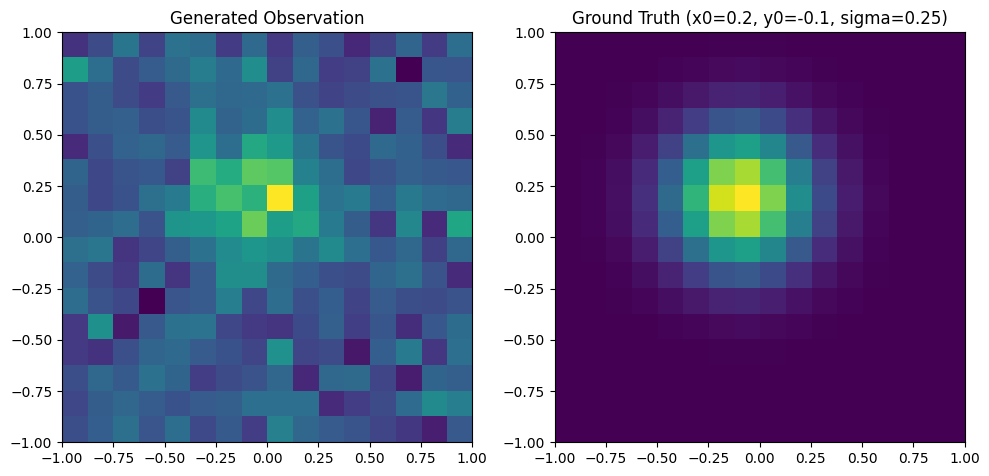

In [3]:
# Define fixed observation noise level
sigma_noise = 0.2

# Set image size
image_size = 16

# Ground truth parameters (x0, y0, sigma)
true_params = (0.2, -0.1, 0.25)

# Convert to torch
true_params_torch = torch.tensor(true_params, dtype=torch.float32).unsqueeze(0)

# Generate a single observation using the sample_data function
obs_image = sample_data(true_params_torch, image_size=image_size, sigma_noise=sigma_noise)

# Convert the single observation to NumPy for plotting
obs_image_np = obs_image.squeeze(0).squeeze(0).cpu().detach().numpy()

# Generate the ground truth image without noise
true_image_torch = sample_data(true_params_torch, image_size=image_size, sigma_noise=0)
true_image_np = true_image_torch.squeeze(0).squeeze(0).cpu().detach().numpy()

# Plot the generated single observation and the ground truth image side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(obs_image_np, origin='lower', cmap='viridis', extent=(-1, 1, -1, 1))
axes[0].set_title('Generated Observation')
axes[1].imshow(true_image_np, origin='lower', cmap='viridis', extent=(-1, 1, -1, 1))
axes[1].set_title(f'Ground Truth (x0={true_params[0]}, y0={true_params[1]}, sigma={true_params[2]})')
plt.tight_layout()
plt.show()

## Sampling the True Posterior

  In this chapter, we will focus on sampling the true posterior using the analytical likelihood and MCMC sampling method. This method estimates the posterior using the full observed image as input. Since it leverages all available information, it provides the most precise posterior.

  ### Steps Involved:

  1. **Define the Log Prior and Log Likelihood Functions:**
      - `log_prior_torch(params_torch)`: Returns the log prior in PyTorch.
      - `log_likelihood_torch(params_torch, obs_torch, sigma_torch)`: Computes the Gaussian likelihood.

  2. **Log Posterior Function:**
      - `log_posterior(params_np, obs_np, sigma_np)`: Bridges the log prior and log likelihood functions for emcee.

  3. **MCMC Sampling:**
      - Initialize walkers near the prior region.
      - Set up the sampler using `emcee.EnsembleSampler`.
      - Perform the burn-in phase and additional steps after burn-in.
      - Extract the samples after discarding some portion.

  4. **Plotting the Results:**
      - Use `corner.corner` to visualize the true posterior and compare it with other methods.

  ### Variables Used:

  - `analytic_samples`: Numpy array containing the MCMC samples.
  - `obs_image`: Torch tensor of the observed image.
  - `true_params`: Tuple containing the ground truth parameters (x0, y0, sigma).
  - `sigma_noise`: Standard deviation of the Gaussian noise added to the observations.

  By following these steps, we can accurately sample the true posterior distribution of the Gaussian blob's center position and radius.


In [4]:
def log_prior_torch(params_torch):
    """
    Returns the log prior in PyTorch.

    Prior:
        x, y ~ Uniform(-1, 1)
        sigma ~ Uniform(0.05, 0.5)
    """
    x, y, s = params_torch[..., 0], params_torch[..., 1], params_torch[..., 2]

    # Check bounds for x, y, and sigma
    outside_bounds = (x < -1) | (x > 1) | (y < -1) | (y > 1) | (s < 0.05) | (s > 0.5)
    if torch.any(outside_bounds):
        return torch.tensor(float('-inf'), device=params_torch.device, dtype=params_torch.dtype)

    # Uniform prior for x, y, and sigma
    logp_x = torch.zeros_like(x)
    logp_y = torch.zeros_like(y)
    logp_s = torch.zeros_like(s)

    return logp_x + logp_y + logp_s

def log_likelihood_torch(params_torch, obs_torch, sigma_torch):
    """
    Gaussian likelihood: obs = model + noise, noise ~ Normal(0, sigma_noise).
    """
    model_torch = forward_model(params_torch, image_size=image_size)
    # model_torch shape: [B, image_size, image_size] if batch, or [1, image_size, image_size] if single
    # obs_torch  shape: must match the same leading dimension
    if model_torch.shape != obs_torch.shape:
        # If single set, expand dims to match
        if model_torch.ndim == 4:
            # unexpected extra dimension
            raise ValueError("Model shape mismatch.")
    residual = obs_torch - model_torch
    # Sum of squared differences
    return -0.5 * torch.sum((residual / sigma_torch)**2, dim=(-2, -1))

def log_posterior(params_np, obs_np, sigma_np):
    """
    Bridging function for emcee. (params_np: shape (3,), or (nwalkers, 3))
    1) Convert from NumPy -> PyTorch
    2) Compute log prior + log likelihood in PyTorch
    3) Return float for emcee
    """
    # handle single or multiple walker input for emcee
    # Typically, emcee passes shape (3,) for single set, or (nwalkers, 3) for vectorization
    params_torch = torch.tensor(params_np, dtype=torch.float32)
    obs_torch    = torch.tensor(obs_np,    dtype=torch.float32)
    sigma_torch  = torch.tensor(sigma_np,  dtype=torch.float32)

    # Ensure we have a batch dimension
    if params_torch.ndim == 1:  # single
        params_torch = params_torch.unsqueeze(0)  # shape [1, 3]
        obs_torch    = obs_torch.unsqueeze(0)     # shape [1, image_size, image_size]
    # else shape is [nwalkers, 3] and [image_size] -> we need to expand obs to [nwalkers, image_size, image_size]
    # but in practice, for emcee, we usually evaluate each walker one at a time,
    # so we won't do multi-walker vectorization here. We'll keep it simpler.

    lp = log_prior_torch(params_torch)  # shape [B]
    if torch.any(torch.isinf(lp)):
        return -np.inf

    ll = log_likelihood_torch(params_torch, obs_torch, sigma_torch)  # shape [B]

    posterior = lp + ll
    # For a single sample or single walker, we have shape [1]. Return scalar
    return posterior.detach().cpu().numpy().squeeze()  # emcee expects a float

In [6]:
# Number of dimensions (x, y, sigma)
ndim = 3
nwalkers = 20

# Initialize walkers near the prior region (in NumPy)
p0 = []
for i in range(nwalkers):
    # x, y ~ Uniform(-1,1); sigma ~ |N(0.3, 0.1)|
    x_init = true_params[0] + np.random.normal(0., 0.1)
    y_init = true_params[1] + np.random.normal(0., 0.1)
    s_init = np.random.uniform(0.05, 0.5)
    p0.append([x_init, y_init, s_init])
p0 = np.array(p0)

# Set up the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior,
    args=[obs_image, sigma_noise]  # pass observation and noise
)

# Burn-in phase
state = sampler.run_mcmc(p0, 100, progress=True)
# Additional steps after burn-in
sampler.run_mcmc(state, 1000, progress=True)

# Extract the samples after discarding some portion
analytic_samples = sampler.get_chain(discard=100, thin=1, flat=True)


<ipython-input-4-49a2f1180803>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_torch    = torch.tensor(obs_np,    dtype=torch.float32)
100%|██████████| 1000/1000 [00:11<00:00, 84.74it/s]


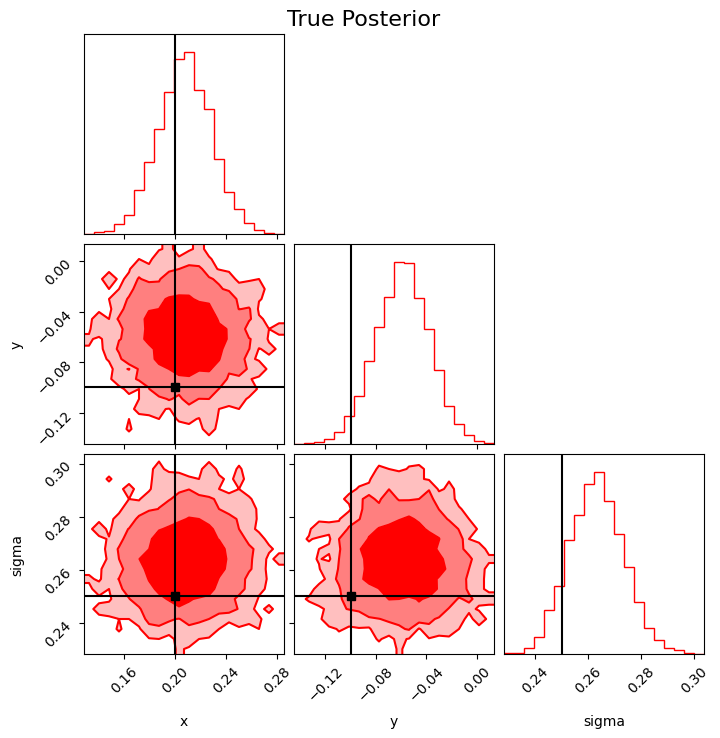

In [7]:
fig = corner.corner(
    analytic_samples,
    labels=["x", "y", "sigma"],
    truths=true_params,
    color='red',
    plot_datapoints=False,
    fill_contours=True,
    levels=[0.68, 0.95, 0.997],
    smooth=0.0,
    truth_color='black'
)
plt.suptitle('True Posterior', fontsize=16)
plt.show()

## Training a Convolutional Neural Network (CNN)

In this section, we will focus on training a convolutional neural network (CNN) to compress the full observed image into low-dimensional summary statistics. This step is commonly used in simulation-based inference to improve the tractability and robustness of density estimation.


### Steps Involved:

1. **Define the CNN Model:**
    - `ConvCompressor`: A convolutional network to predict the model parameters (x0, y0, sigma) of the Gaussian blob.

2. **Generate Dataset:**
    - Generate data in batches using the `sample_prior` and `sample_data` functions.
    - Split the data into training and validation sets.
    - Create PyTorch DataLoaders for training and validation.

3. **Training Loop:**
    - Define the loss function and optimizer.
    - Train the model for a specified number of epochs.
    - Track and plot the training and validation losses.

4. **Reconstruct the Image:**
    - Use the trained model to predict the parameters of the observed image.
    - Reconstruct the image from the predicted parameters.
    - Plot the true observation, reconstructed image, and true no noise Gaussian blob image.

### Variables Used:

- `compressor_model`: The CNN model for compression.
- `train_loader`, `valid_loader`: DataLoaders for training and validation data.
- `criterion`: Loss function (Mean Squared Error).
- `optimizer`: Optimizer (Adam).
- `epochs`: Number of training epochs.
- `train_losses`, `valid_losses`: Lists to store training and validation losses.
- `obs_image`: Torch tensor of the observed image.
- `true_image_np`: Numpy array of the ground truth image without noise.
- `reconstructed_image`: Numpy array of the reconstructed image from the predicted parameters.

By following these steps, we can train a CNN to compress the observed image into low-dimensional summary statistics, which can be used for further inference tasks.


In [8]:
# Generate dataset
num_samples = 10000

# Generate data in batches
batch_size = 32
num_batches = num_samples // batch_size
all_data = []
all_params = []

for _ in range(num_batches):
    # Sample prior model parameters
    params_torch = sample_prior(batch_size)

    # Generate corresponding data with sample_data
    batch_data = sample_data(params_torch, image_size=image_size, sigma_noise=0.) # We'll add noise later during training

    all_data.append(batch_data)
    all_params.append(params_torch)

# Concatenate all batches into a single tensor
all_data = torch.cat(all_data, dim=0)
all_params = torch.cat(all_params, dim=0)

# Train / valid split
split_idx = int(0.8 * num_samples)
train_data = all_data[:split_idx]
valid_data = all_data[split_idx:]
train_params = all_params[:split_idx]
valid_params = all_params[split_idx:]

print("Train data shape:", train_data.shape)
print("Valid data shape:", valid_data.shape)
print("Train params shape:", train_params.shape)
print("Valid params shape:", valid_params.shape)

# Create PyTorch DataLoaders
train_dataset = TensorDataset(train_data, train_params)
valid_dataset = TensorDataset(valid_data, valid_params)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


Train data shape: torch.Size([8000, 1, 16, 16])
Valid data shape: torch.Size([1984, 1, 16, 16])
Train params shape: torch.Size([8000, 3])
Valid params shape: torch.Size([1984, 3])


Epoch [1/100] | Train Loss: 0.0508 | Val Loss: 0.0197
Epoch [2/100] | Train Loss: 0.0257 | Val Loss: 0.0202
Epoch [3/100] | Train Loss: 0.0212 | Val Loss: 0.0149
Epoch [4/100] | Train Loss: 0.0186 | Val Loss: 0.0126
Epoch [5/100] | Train Loss: 0.0174 | Val Loss: 0.0137
Epoch [6/100] | Train Loss: 0.0160 | Val Loss: 0.0134
Epoch [7/100] | Train Loss: 0.0150 | Val Loss: 0.0098
Epoch [8/100] | Train Loss: 0.0146 | Val Loss: 0.0107
Epoch [9/100] | Train Loss: 0.0132 | Val Loss: 0.0111
Epoch [10/100] | Train Loss: 0.0129 | Val Loss: 0.0094
Epoch [11/100] | Train Loss: 0.0126 | Val Loss: 0.0102
Epoch [12/100] | Train Loss: 0.0122 | Val Loss: 0.0083
Epoch [13/100] | Train Loss: 0.0117 | Val Loss: 0.0095
Epoch [14/100] | Train Loss: 0.0112 | Val Loss: 0.0072
Epoch [15/100] | Train Loss: 0.0112 | Val Loss: 0.0071
Epoch [16/100] | Train Loss: 0.0108 | Val Loss: 0.0058
Epoch [17/100] | Train Loss: 0.0101 | Val Loss: 0.0066
Epoch [18/100] | Train Loss: 0.0096 | Val Loss: 0.0063
Epoch [19/100] | Tr

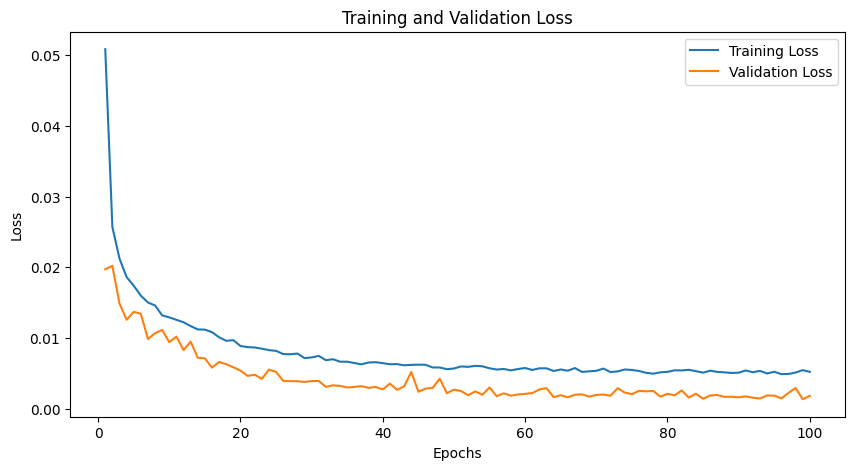

In [9]:
class ConvCompressor(nn.Module):
    """
    A convolutional network to predict the model parameters (x0, y0, sigma) of the Gaussian blob.
    """
    def __init__(self, image_size=16, latent_dim=3):
        super().__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim

        # -------------------------
        #   Encoder
        # -------------------------
        # Input shape: [B, 1, 16, 16]
        # Each stride=2 halves W & H => 16 -> 8 -> 4
        self.encoder = nn.Sequential(
            nn.Conv2d(1,  16,  kernel_size=3, stride=2, padding=1),   # -> [B, 16, 8, 8]
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),    # -> [B, 8, 4, 4]
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        # Flatten 8×4×4 = 128 -> hidden_dim
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, latent_dim)

    def forward(self, x):
        # x shape: [B, 1, 16, 16]
        x = self.encoder(x)           # -> [B, 16, 4, 4]
        x = x.view(x.size(0), -1)     # flatten to [B, 256]
        x = self.fc1(x)               # -> [B, 128]
        params = self.fc2(x)           # -> [B, latent_dim]
        return params

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 3
compressor_model = ConvCompressor(image_size=image_size, latent_dim=latent_dim).to(device)
compressor_model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(compressor_model.parameters(), lr=1e-3)

# Training loop
epochs = 100
train_losses = []
valid_losses = []

for epoch in range(1, epochs+1):
    compressor_model.train()
    running_train_loss = 0.0
    for (input_batch, params) in train_loader:
        input_batch = input_batch.to(device)  # shape [B,1,image_size,image_size]
        params = params.to(device)

        # Add observatio noise randomly on the fly
        noise = torch.randn_like(input_batch) * sigma_noise
        input_batch = input_batch + noise

        optimizer.zero_grad()
        outputs = compressor_model(input_batch)
        loss = criterion(outputs, params)  # Use the ground truth parameters
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * input_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    compressor_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for (input_batch, params)  in valid_loader:
            input_batch = input_batch.to(device)  # shape [B,1,image_size,image_size]
            params = params.to(device)
            outputs = compressor_model(input_batch)
            loss = criterion(outputs, params)  # Use the ground truth parameters
            running_val_loss += loss.item() * input_batch.size(0)
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)
    valid_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch}/{epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

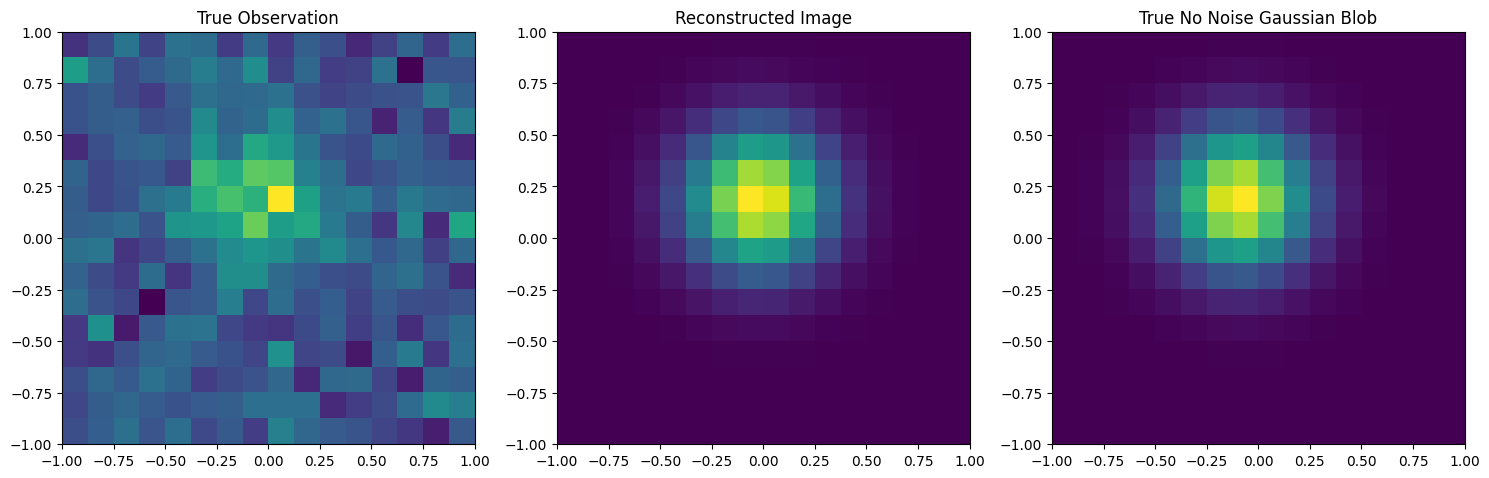

In [10]:
# Reconstruct the image from the encoding prediction
compressor_model.eval()
with torch.no_grad():
    predicted_params = compressor_model(obs_image.to(device))
    reconstructed_image_torch = forward_model(predicted_params, image_size=image_size)
    reconstructed_image = reconstructed_image_torch.cpu().squeeze(0).numpy()

# Plot the true observation, reconstructed image, and true no noise Gaussian blob image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Determine the vmin and vmax for consistent color scaling
vmin = min(reconstructed_image.min(), true_image_np.min())
vmax = max(reconstructed_image.max(), true_image_np.max())

# True observation
axes[0].imshow(obs_image_np, origin='lower', cmap='viridis', extent=(-1, 1, -1, 1))
axes[0].set_title('True Observation')

# Reconstructed image
axes[1].imshow(reconstructed_image, origin='lower', cmap='viridis', extent=(-1, 1, -1, 1), vmin=vmin, vmax=vmax)
axes[1].set_title('Reconstructed Image')

# True no noise Gaussian blob image
axes[2].imshow(true_image_np, origin='lower', cmap='viridis', extent=(-1, 1, -1, 1), vmin=vmin, vmax=vmax)
axes[2].set_title('True No Noise Gaussian Blob')

plt.tight_layout()
plt.show()

## Approximate Bayesian Computation (ABC)

In this chapter, we will focus on applying Approximate Bayesian Computation (ABC) to infer the posterior distribution of the model parameters. ABC is a simulation-based method that generates simulated noisy data from randomly sampled model parameters and compares it with the observed data. If the simulated data is sufficiently close to the observed data, the model parameter is retained as a sample from the posterior.


### Steps Involved:

1. **Define the Proposal Distribution:**
    - Initially, sample from the prior distribution.
    - In subsequent rounds, fit a Gaussian proposal distribution to the accepted samples from the previous round.

2. **Generate Simulated Data:**
    - Use the `sample_data` function to generate noisy observations from the sampled parameters.

3. **Compute Distances:**
    - Compare the compressed statistics of the simulated data with the observed data using a distance metric.

4. **Accept or Reject Samples:**
    - Accept samples if the distance is below a predefined threshold.
    - Gradually reduce the threshold in subsequent rounds to refine the posterior samples.

5. **Fit the Proposal Distribution:**
    - Fit a Gaussian distribution to the accepted samples to use as the proposal distribution in the next round.

### Variables Used:

- `abc_samples`: Numpy array containing the accepted samples from ABC.
- `compressor_model`: The CNN model used to compress the observed image into low-dimensional summary statistics.
- `obs_image`: Torch tensor of the observed image.
- `true_params`: Tuple containing the ground truth parameters (x0, y0, sigma).
- `thresholds`: Array of thresholds used in each round of ABC.
- `num_thresholds`: Number of thresholds (rounds) used in ABC.

By following these steps, we can use ABC to approximate the posterior distribution of the Gaussian blob's center position and radius.

In [12]:
def fit_gaussian_to_samples(samples):
    """
    samples: shape [N, 3] in torch
    Returns mean (shape [3]) and covariance (shape [3,3])
    """
    mean = torch.mean(samples, dim=0)
    cov = torch.cov(samples.T)  # shape (3,3)
    return mean, cov

def clamp_params(params):
    """
    Ensures x,y in [-1,1], sigma in [0.05,0.5].
    params: shape [B,3]
    """
    params[:, 0] = torch.clamp(params[:, 0], -1.0, 1.0)   # x
    params[:, 1] = torch.clamp(params[:, 1], -1.0, 1.0)   # y
    params[:, 2] = torch.clamp(params[:, 2],  0.05, 0.5)  # sigma
    return params

def sample_from_gaussian(mean, cov, n):
    distr = MultivariateNormal(mean, cov)
    return distr.sample((n,))

def abc_sampling_active(
    model,
    true_obs,
    num_samples=1000,
    threshold_schedule=[0.2, 0.1, 0.05],
    batch_size=256,
    max_draws_per_round=[5000, 5000, 5000],
    image_size=16,
    sigma_noise=0.05
):
    model.eval()
    true_obs = true_obs.to(device)

    # Encode the true observation once
    with torch.no_grad():
        true_latent = model(true_obs).detach().cpu().numpy()

    current_mean = None
    current_cov = None

    # For fitting the proposal distribution, we still keep a "global_accepted" set,
    # but for the final posterior, we keep only the "last_round_accepted".
    global_accepted = None
    last_round_accepted = None

    for round_i, (threshold, max_draws) in enumerate(zip(threshold_schedule, max_draws_per_round)):
        print(f"=== ABC Round {round_i+1}/{len(threshold_schedule)}, threshold={threshold:.3f}, max_draws={max_draws} ===")

        # Decide proposal
        if round_i == 0 or global_accepted is None:
            def proposal_sample(n):
                return sample_prior(n)  # shape [n,3]
        else:
            def proposal_sample(n):
                params = sample_from_gaussian(current_mean, current_cov, n)
                params = clamp_params(params)
                return params

        newly_accepted = []
        draws_this_round = 0

        while draws_this_round < max_draws:
            params_torch = proposal_sample(batch_size).to(device)
            sim_obs = sample_data(params_torch, image_size=image_size, sigma_noise=sigma_noise)

            with torch.no_grad():
                sim_latent = model(sim_obs).detach().cpu().numpy()

            distances = np.linalg.norm(sim_latent - true_latent, axis=1)

            for i in range(batch_size):
                if distances[i] < threshold:
                    newly_accepted.append(params_torch[i].cpu().numpy())

            draws_this_round += batch_size

        newly_accepted = np.array(newly_accepted)
        print(f"Round {round_i+1}: drew={draws_this_round}, accepted={len(newly_accepted)}")

        # If no accepted, break
        if len(newly_accepted) == 0:
            print("No new accepted samples at this threshold. Stopping.")
            break

        # *This* round's accepted (for final distribution)
        last_round_accepted = newly_accepted

        # Merge with global accepted for proposal fitting
        if global_accepted is None:
            global_accepted = newly_accepted
        else:
            global_accepted = np.vstack([global_accepted, newly_accepted])

        # Fit new proposal from global_accepted
        ga_torch = torch.tensor(global_accepted, dtype=torch.float32)
        current_mean, current_cov = fit_gaussian_to_samples(ga_torch)
        current_cov = current_cov + 1e-4 * torch.eye(3)

    # Return only the final round’s accepted samples
    if last_round_accepted is None or len(last_round_accepted) == 0:
        print("No accepted samples in the final round.")
        return np.array([])
    else:
        # We can slice if we only want `num_samples`
        return last_round_accepted[:num_samples]



In [13]:
num_thresholds = 15
thresholds = np.linspace(1.5,0.1, num_thresholds) # gradually smaller thresholds

abc_samples = abc_sampling_active(
    model=compressor_model,
    true_obs=obs_image.to(device),
    num_samples=1000,         # want 1000 final accepted
    threshold_schedule=thresholds,
    batch_size=256,
    max_draws_per_round=[10000] * (num_thresholds - 1) + [500000], # e.g. 3000 draws per round
    image_size=16,
    sigma_noise=sigma_noise
)

=== ABC Round 1/15, threshold=1.500, max_draws=10000 ===
Round 1: drew=10240, accepted=10220
=== ABC Round 2/15, threshold=1.400, max_draws=10000 ===
Round 2: drew=10240, accepted=10171
=== ABC Round 3/15, threshold=1.300, max_draws=10000 ===
Round 3: drew=10240, accepted=10055
=== ABC Round 4/15, threshold=1.200, max_draws=10000 ===
Round 4: drew=10240, accepted=9874
=== ABC Round 5/15, threshold=1.100, max_draws=10000 ===
Round 5: drew=10240, accepted=9487
=== ABC Round 6/15, threshold=1.000, max_draws=10000 ===
Round 6: drew=10240, accepted=9012
=== ABC Round 7/15, threshold=0.900, max_draws=10000 ===
Round 7: drew=10240, accepted=8280
=== ABC Round 8/15, threshold=0.800, max_draws=10000 ===
Round 8: drew=10240, accepted=7532
=== ABC Round 9/15, threshold=0.700, max_draws=10000 ===
Round 9: drew=10240, accepted=6629
=== ABC Round 10/15, threshold=0.600, max_draws=10000 ===
Round 10: drew=10240, accepted=5594
=== ABC Round 11/15, threshold=0.500, max_draws=10000 ===
Round 11: drew=10

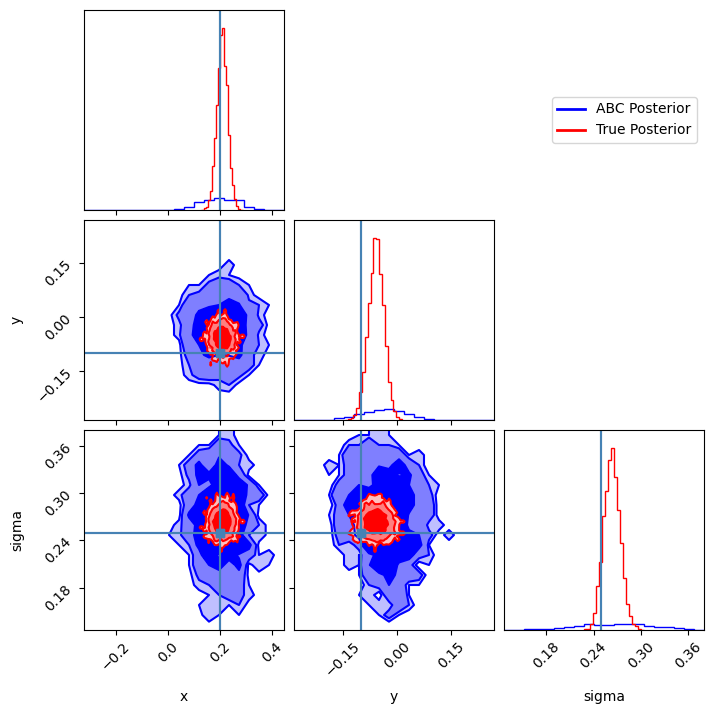

In [14]:
# Plot the accepted samples from ABC and MCMC samples
fig = corner.corner(abc_samples, labels=["x", "y", "sigma"], truths=true_params, color='blue', plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, normalize1d=True)
corner.corner(analytic_samples, labels=["x", "y", "sigma"], truths=true_params, color='red', fig=fig, plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, normalize1d=True)
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=2, label='ABC Posterior'),
                    plt.Line2D([0], [0], color='red', lw=2, label='True Posterior')],
                    loc='upper right', bbox_to_anchor=(1.0, 2.7))
plt.show()

## Neural Posterior Estimator (With Compression)

In this section, we train a neural network to predict the posterior of model parameters based on the compressed statistic of simulated noisy observations obtained from applying our compressor convolution model.


### Steps Involved

1. **Generate Training Data:**
    - Generate true model parameters using the `sample_prior` function.
    - Generate simulated data observations using the `sample_data` function.
    - Split the data into training and validation sets.
    - Create PyTorch DataLoader objects for training and validation.

2. **Define the CNN Model:**
    - `ConvCompressor`: A convolutional network to predict the model parameters (x0, y0, sigma) of the Gaussian blob.

3. **Training Loop:**
    - Define the loss function and optimizer.
    - Train the model for a specified number of epochs.
    - Track and plot the training and validation losses.

4. **Reconstruct the Image:**
    - Use the trained model to predict the parameters of the observed image.
    - Reconstruct the image from the predicted parameters.
    - Plot the true observation, reconstructed image, and true no noise Gaussian blob image.

### Variables Used:

- `compressor_model`: The CNN model for compression.
- `train_loader`, `valid_loader`: DataLoaders for training and validation data.
- `criterion`: Loss function (Mean Squared Error).
- `optimizer`: Optimizer (Adam).
- `epochs`: Number of training epochs.
- `train_losses`, `valid_losses`: Lists to store training and validation losses.
- `obs_image`: Torch tensor of the observed image.
- `true_image_np`: Numpy array of the ground truth image without noise.
- `reconstructed_image`: Numpy array of the reconstructed image from the predicted parameters.

In [15]:
# Generate training data of true model parameters and compressed encoding statistic
# Number of samples to generate
num_samples = 20000

# Generate true model parameters
params_torch = sample_prior(num_samples)

# Generate simulated data observations
simulated_data = sample_data(params_torch, image_size=image_size, sigma_noise=sigma_noise)

# Apply the convolutional compressor model to get the compressed encoding statistic
compressor_model.eval()
with torch.no_grad():
    compressed_statistic = compressor_model(simulated_data.to(device)).cpu()

# Split into training and validation sets
split_idx = int(0.8 * num_samples)
train_params = params_torch[:split_idx]
valid_params = params_torch[split_idx:]
train_stat = compressed_statistic[:split_idx]
valid_stat = compressed_statistic[split_idx:]

# Create PyTorch DataLoader objects
batch_size = 64
train_dataset = TensorDataset(train_params, train_stat)
valid_dataset = TensorDataset(valid_params, valid_stat)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

Epoch [1/50] | Train Loss: -5.3459 | Val Loss: -7.2994
Epoch [2/50] | Train Loss: -7.2223 | Val Loss: -7.2412
Epoch [3/50] | Train Loss: -7.3647 | Val Loss: -7.2821
Epoch [4/50] | Train Loss: -7.3954 | Val Loss: -7.4930
Epoch [5/50] | Train Loss: -7.4290 | Val Loss: -7.3971
Epoch [6/50] | Train Loss: -7.5239 | Val Loss: -7.5829
Epoch [7/50] | Train Loss: -7.5455 | Val Loss: -7.5748
Epoch [8/50] | Train Loss: -7.5905 | Val Loss: -7.6105
Epoch [9/50] | Train Loss: -7.5975 | Val Loss: -7.3870
Epoch [10/50] | Train Loss: -7.6308 | Val Loss: -7.5802
Epoch [11/50] | Train Loss: -7.6485 | Val Loss: -7.5714
Epoch [12/50] | Train Loss: -7.6330 | Val Loss: -7.5151
Epoch [13/50] | Train Loss: -7.6843 | Val Loss: -7.4951
Epoch [14/50] | Train Loss: -7.6880 | Val Loss: -7.7408
Epoch [15/50] | Train Loss: -7.6787 | Val Loss: -7.7259
Epoch [16/50] | Train Loss: -7.6289 | Val Loss: -7.7390
Epoch [17/50] | Train Loss: -7.7051 | Val Loss: -7.7503
Epoch [18/50] | Train Loss: -7.6948 | Val Loss: -7.6974
E

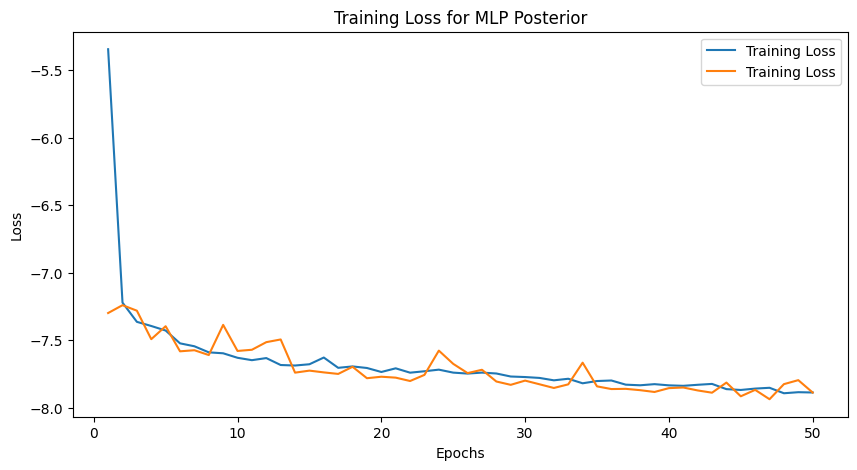

In [17]:
class MLPPosterior(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=6):
        super(MLPPosterior, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.output_dim = output_dim

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        mean = x[:, :self.output_dim//2]
        log_var = x[:, self.output_dim//2:]
        return mean, log_var

# Instantiate the model
posterior_model = MLPPosterior(input_dim=3, hidden_dim=64, output_dim=6).to(device)

# Loss and optimizer
posterior_optimizer = optim.Adam(posterior_model.parameters(), lr=1e-3)

def negative_log_likelihood(mean, log_var, true_params):
    var = torch.exp(log_var)
    nll = 0.5 * torch.sum(log_var + (true_params - mean)**2 / var, dim=1)
    return torch.mean(nll)

# Training loop
posterior_epochs = 50
posterior_train_losses = []
posterior_valid_losses = []

for epoch in range(1, posterior_epochs + 1):
    posterior_model.train()
    running_train_loss = 0.0
    for (params, compressed_stat) in train_loader:
        params = params.to(device)
        compressed_stat = compressed_stat.to(device)

        posterior_optimizer.zero_grad()
        mean, log_var = posterior_model(compressed_stat)

        loss = negative_log_likelihood(mean, log_var, params)
        loss.backward()
        posterior_optimizer.step()

        running_train_loss += loss.item() * params.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    posterior_train_losses.append(epoch_train_loss)

    # Validation
    posterior_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for (params, compressed_stat) in valid_loader:
            params = params.to(device)
            compressed_stat = compressed_stat.to(device)
            mean, log_var = posterior_model(compressed_stat)
            loss = negative_log_likelihood(mean, log_var, params)
            running_val_loss += loss.item() * params.size(0)
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)
    posterior_valid_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch}/{posterior_epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, posterior_epochs + 1), posterior_train_losses, label='Training Loss')
plt.plot(range(1, posterior_epochs + 1), posterior_valid_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for MLP Posterior')
plt.legend()
plt.show()

<ipython-input-19-9e9d8bd0a120>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, log_var = posterior_model(torch.tensor(obs_compressed_stat, dtype=torch.float32).to(device))


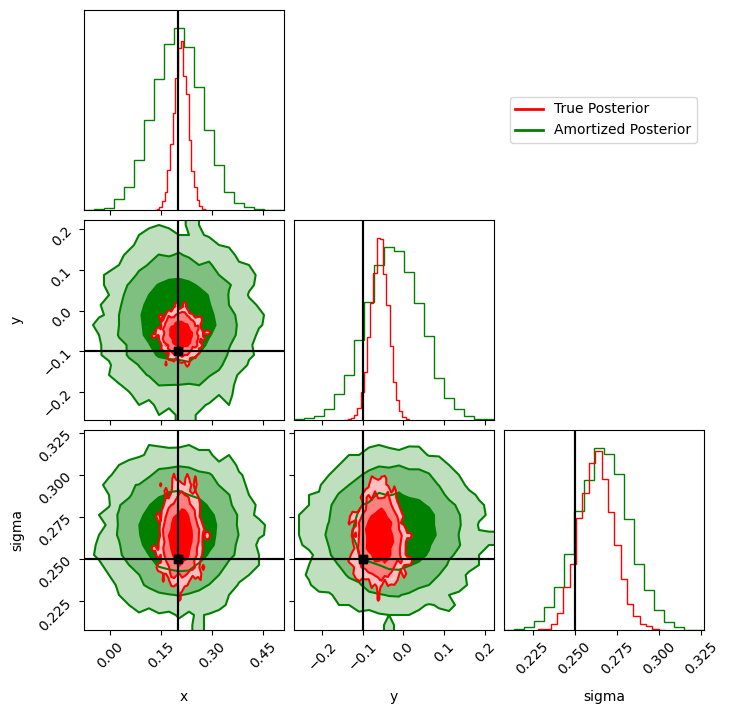

In [19]:
# Generate samples from the learned posterior neural network
posterior_model.eval()
with torch.no_grad():
    obs_compressed_stat = compressor_model(obs_image.to(device))
    mean, log_var = posterior_model(torch.tensor(obs_compressed_stat, dtype=torch.float32).to(device))
    var = torch.exp(log_var)
    std = torch.sqrt(var)
    posterior_nn_samples = mean + std * torch.randn(20000, mean.size(1)).to(device)
    posterior_nn_samples = posterior_nn_samples.detach().cpu().numpy()

# Plot the MCMC samples and the posterior neural network samples
fig = corner.corner(posterior_nn_samples, labels=["x", "y", "sigma"], truths=true_params, color='green', plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Posterior NN Samples', truth_color='black')
corner.corner(analytic_samples, labels=["x", "y", "sigma"], truths=true_params, color='red', fig=fig, plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='MCMC Samples', truth_color='black')
plt.legend(handles=[plt.Line2D([0], [0], color='red', lw=2, label='True Posterior'),
                    plt.Line2D([0], [0], color='green', lw=2, label='Amortized Posterior')],
                    loc='upper right', bbox_to_anchor=(1.0, 2.7))
plt.show()


## Neural Likelihood Estimator (With Compression)

In this chapter, we train a neural network to predict the likelihood probability of the compressed statistic given model parameters. In combination with the prior, this learned surrogate likelihood can be evaluated to sample from the posterior distribution using MCMC methods.


### Steps Involved:

1. **Define the Likelihood Model:**
    - `MLPLikelihood`: A multi-layer perceptron (MLP) to predict the likelihood distribution of the compressed data given the model parameters.

2. **Generate Training Data:**
    - Generate true model parameters using the `sample_prior` function.
    - Generate simulated data observations using the `sample_data` function.
    - Apply the convolutional compressor model to get the compressed encoding statistic.
    - Split the data into training and validation sets.
    - Create PyTorch DataLoader objects for training and validation.

3. **Training Loop:**
    - Define the loss function and optimizer.
    - Train the model for a specified number of epochs.
    - Track and plot the training and validation losses.

4. **Inference:**
    - Use the trained likelihood model to predict the likelihood distribution of the observed data.
    - Combine the learned likelihood with a prior to obtain the posterior distribution.
    - Use MCMC to sample the posterior.

### Variables Used:

- `likelihood_model`: The MLP model for likelihood estimation.
- `train_loader`, `valid_loader`: DataLoaders for training and validation data.
- `criterion`: Loss function (Negative Log Likelihood).
- `optimizer`: Optimizer (Adam).
- `epochs`: Number of training epochs.
- `train_losses`, `valid_losses`: Lists to store training and validation losses.
- `obs_image`: Torch tensor of the observed image.
- `obs_compressed_stat`: Compressed statistics of the observed image.
- `likelihood_nn_samples`: Numpy array containing the MCMC samples from the learned likelihood model.

Epoch [1/50] | Train Loss: -5.4328 | Val Loss: -7.2860
Epoch [2/50] | Train Loss: -7.3615 | Val Loss: -7.4336
Epoch [3/50] | Train Loss: -7.5044 | Val Loss: -7.5315
Epoch [4/50] | Train Loss: -7.5676 | Val Loss: -7.5656
Epoch [5/50] | Train Loss: -7.6235 | Val Loss: -7.6695
Epoch [6/50] | Train Loss: -7.6672 | Val Loss: -7.4836
Epoch [7/50] | Train Loss: -7.6749 | Val Loss: -7.7624
Epoch [8/50] | Train Loss: -7.7331 | Val Loss: -7.7627
Epoch [9/50] | Train Loss: -7.7453 | Val Loss: -7.8033
Epoch [10/50] | Train Loss: -7.7462 | Val Loss: -7.8674
Epoch [11/50] | Train Loss: -7.7671 | Val Loss: -7.7292
Epoch [12/50] | Train Loss: -7.7989 | Val Loss: -7.7871
Epoch [13/50] | Train Loss: -7.7922 | Val Loss: -7.7798
Epoch [14/50] | Train Loss: -7.8026 | Val Loss: -7.8518
Epoch [15/50] | Train Loss: -7.8175 | Val Loss: -7.8462
Epoch [16/50] | Train Loss: -7.8154 | Val Loss: -7.9033
Epoch [17/50] | Train Loss: -7.8347 | Val Loss: -7.8380
Epoch [18/50] | Train Loss: -7.8347 | Val Loss: -7.8458
E

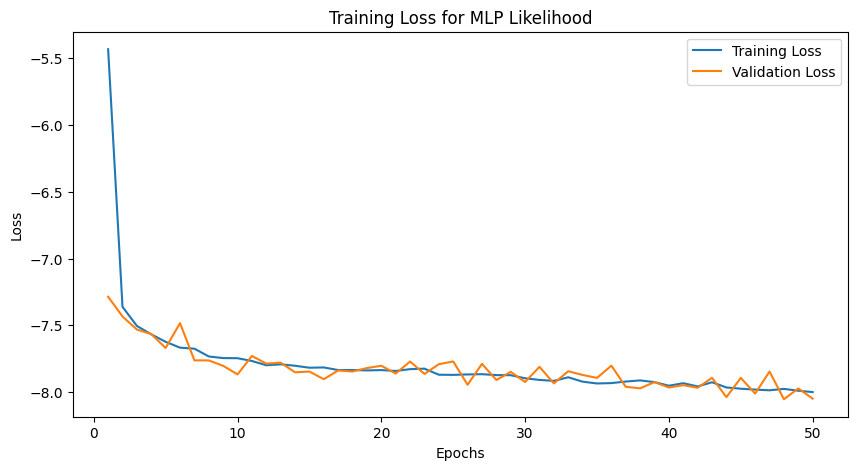

In [21]:
class MLPLikelihood(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=6):
        super(MLPLikelihood, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.output_dim = output_dim

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        mean = x[:, :self.output_dim//2]
        log_var = x[:, self.output_dim//2:]
        return mean, log_var

# Instantiate the model
likelihood_model = MLPLikelihood(input_dim=3, hidden_dim=64, output_dim=6).to(device)

# Loss and optimizer
likelihood_optimizer = optim.Adam(likelihood_model.parameters(), lr=1e-3)

def negative_log_likelihood(mean, log_var, true_stat):
    var = torch.exp(log_var)
    nll = 0.5 * torch.sum(log_var + (true_stat - mean)**2 / var, dim=1)
    return torch.mean(nll)

# Training loop
likelihood_epochs = 50
likelihood_train_losses = []
likelihood_valid_losses = []

for epoch in range(1, likelihood_epochs + 1):
    likelihood_model.train()
    running_train_loss = 0.0
    for (params, compressed_stat) in train_loader:
        params = params.to(device)
        compressed_stat = compressed_stat.to(device)

        likelihood_optimizer.zero_grad()
        mean, log_var = likelihood_model(params)

        loss = negative_log_likelihood(mean, log_var, compressed_stat)
        loss.backward()
        likelihood_optimizer.step()

        running_train_loss += loss.item() * params.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    likelihood_train_losses.append(epoch_train_loss)

    # Validation
    likelihood_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for (params, compressed_stat) in valid_loader:
            params = params.to(device)
            compressed_stat = compressed_stat.to(device)
            mean, log_var = likelihood_model(params)
            loss = negative_log_likelihood(mean, log_var, compressed_stat)
            running_val_loss += loss.item() * params.size(0)
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)
    likelihood_valid_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch}/{likelihood_epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, likelihood_epochs + 1), likelihood_train_losses, label='Training Loss')
plt.plot(range(1, likelihood_epochs + 1), likelihood_valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for MLP Likelihood')
plt.legend()
plt.show()

In [23]:
def log_prior(params):
    """
    Log prior for the parameters.
    Prior:
        x, y ~ Uniform(-1, 1)
        sigma ~ Uniform(0.05, 0.5)
    """
    x, y, sigma = params[..., 0], params[..., 1], params[..., 2]
    if torch.any((x < -1) | (x > 1) | (y < -1) | (y > 1) | (sigma < 0.05) | (sigma > 0.5)):
        return torch.tensor(float('-inf'), device=params.device, dtype=params.dtype)
    return torch.zeros(params.shape[:-1], device=params.device, dtype=params.dtype)

def log_likelihood(params, obs_stat):
    """
    Log likelihood for the parameters given the observed statistics.
    """
    mean, log_var = likelihood_model(params)
    var = torch.exp(log_var)
    nll = 0.5 * torch.sum(log_var + (obs_stat - mean)**2 / var, dim=-1)
    return -nll

def log_posterior(params_np, obs_stat_np):
    """
    Log posterior for the parameters given the observed statistics.
    """
    params = torch.tensor(params_np, dtype=torch.float32, device=device)[None]
    obs_stat = torch.tensor(obs_stat_np, dtype=torch.float32, device=device)
    lp = log_prior(params)
    if torch.any(torch.isinf(lp)):
        return -np.inf
    ll = log_likelihood(params, obs_stat)
    return (lp + ll).detach().cpu().numpy()

# Use MCMC to sample the posterior
nwalkers = 20
ndim = 3

# Initialize walkers near the prior region (in NumPy)
p0 = []
for i in range(nwalkers):
    # x, y ~ Uniform(-1,1); sigma ~ |N(0.3, 0.1)|
    x_init = true_params[0] + np.random.normal(0., 0.1)
    y_init = true_params[1] + np.random.normal(0., 0.1)
    s_init = abs(np.random.normal(0.3, 0.1))
    p0.append([x_init, y_init, s_init])
p0 = np.array(p0)

obs_compressed_statistic = compressor_model(obs_image.to(device))

# Set up the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior,
    args=[obs_compressed_statistic.detach().cpu().numpy()]  # pass the observed statistics
)

# Burn-in phase
state = sampler.run_mcmc(p0, 100, progress=True)
# Additional steps after burn-in
sampler.run_mcmc(state, 1000, progress=True)

# Extract the samples after discarding some portion
likelihood_nn_samples = sampler.get_chain(discard=100, thin=1, flat=True)

100%|██████████| 1000/1000 [00:18<00:00, 53.67it/s]


<ipython-input-26-4d52f96f791b>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, log_var = posterior_model(torch.tensor(obs_compressed_stat, dtype=torch.float32).to(device))


torch.Size([1, 3]) torch.Size([1, 3])


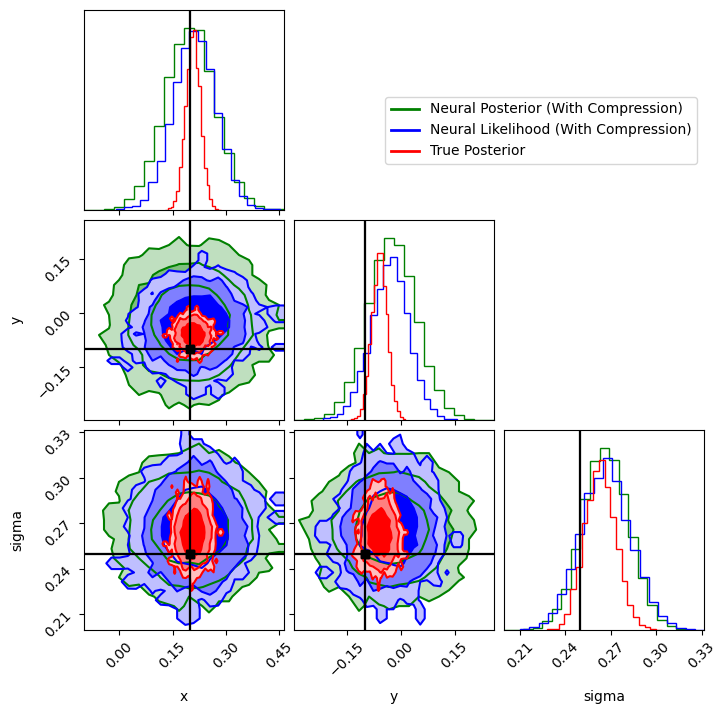

In [26]:
# Generate samples from the learned posterior neural network
posterior_model.eval()
with torch.no_grad():
    obs_compressed_stat = compressor_model(obs_image.to(device))
    mean, log_var = posterior_model(torch.tensor(obs_compressed_stat, dtype=torch.float32).to(device))
    print(mean.shape, log_var.shape)
    var = torch.exp(log_var)
    std = torch.sqrt(var)
    posterior_nn_samples = mean + std * torch.randn(20000, mean.size(1)).to(device)
    posterior_nn_samples = posterior_nn_samples.detach().cpu().numpy()

# Plot the MCMC samples, the posterior neural network samples, and the likelihood + MCMC samples
fig = corner.corner(posterior_nn_samples, labels=["x", "y", "sigma"], truths=true_params, color='green', plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Posterior NN Samples', truth_color='black')
corner.corner(likelihood_nn_samples, labels=["x", "y", "sigma"], truths=true_params, color='blue', fig=fig, plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Likelihood NN + MCMCs', truth_color='black')
corner.corner(analytic_samples, labels=["x", "y", "sigma"], truths=true_params, color='red', fig=fig, plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='MCMC Samples', truth_color='black')
plt.legend(handles=[plt.Line2D([0], [0], color='green', lw=2, label='Neural Posterior (With Compression)'),
                    plt.Line2D([0], [0], color='blue', lw=2, label='Neural Likelihood (With Compression)'),
                    plt.Line2D([0], [0], color='red', lw=2, label='True Posterior')],
                    loc='upper right', bbox_to_anchor=(1.0, 2.7))
plt.show()

## Neural Posterior Estimator (No Compression)

In this chapter, we will focus on training a convolutional neural network (CNN) to directly map the observed image to the posterior distribution of model parameters. This method utilizes the full information content of the observed data, ensuring consistency with the analytical posterior obtained using the full analytical likelihood.

### Steps Involved:

1. **Generate Training Data:**
    - Generate true model parameters using the `sample_prior` function.
    - Generate simulated data observations using the `sample_data` function.
    - Split the data into training and validation sets.
    - Create PyTorch DataLoader objects for training and validation.

2. **Define the CNN Model:**
    - `ConvPosterior`: A convolutional network to predict the mean and log variance of the model parameters (x0, y0, sigma) of the Gaussian blob.

3. **Training Loop:**
    - Define the loss function and optimizer.
    - Train the model for a specified number of epochs.
    - Track and plot the training and validation losses.

4. **Reconstruct the Image:**
    - Use the trained model to predict the parameters of the observed image.
    - Reconstruct the image from the predicted parameters.
    - Plot the true observation, reconstructed image, and true no noise Gaussian blob image.

### Variables Used:

- `posterior_conv_model`: The CNN model for posterior inference without compression.
- `train_loader`, `valid_loader`: DataLoaders for training and validation data.
- `criterion`: Loss function (Negative Log Likelihood).
- `optimizer`: Optimizer (Adam).
- `epochs`: Number of training epochs.
- `train_losses`, `valid_losses`: Lists to store training and validation losses.
- `obs_image`: Torch tensor of the observed image.
- `true_image_np`: Numpy array of the ground truth image without noise.
- `reconstructed_image`: Numpy array of the reconstructed image from the predicted parameters.

In [27]:
# Generate training data of true model parameters and compressed encoding statistic
# Number of samples to generate
num_samples = 20000

# Generate true model parameters
params_torch = sample_prior(num_samples)

# Generate simulated data observations
simulated_data = sample_data(params_torch, image_size=image_size, sigma_noise=0.) # We will add the noise during training

# Split into training and validation sets
split_idx = int(0.8 * num_samples)
train_params = params_torch[:split_idx]
valid_params = params_torch[split_idx:]
train_input = simulated_data[:split_idx]
valid_input = simulated_data[split_idx:]

# Create PyTorch DataLoader objects
batch_size = 64
train_dataset = TensorDataset(train_params, train_input)
valid_dataset = TensorDataset(valid_params, valid_input)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

Epoch [1/150] | Train Loss: -4.4223 | Val Loss: -6.0214
Epoch [2/150] | Train Loss: -6.3227 | Val Loss: -6.5815
Epoch [3/150] | Train Loss: -6.9582 | Val Loss: -7.7449
Epoch [4/150] | Train Loss: -7.1331 | Val Loss: -8.0562
Epoch [5/150] | Train Loss: -7.3309 | Val Loss: -8.1399
Epoch [6/150] | Train Loss: -7.7271 | Val Loss: -8.4938
Epoch [7/150] | Train Loss: -7.8045 | Val Loss: -8.8462
Epoch [8/150] | Train Loss: -7.9184 | Val Loss: -9.0371
Epoch [9/150] | Train Loss: -7.9416 | Val Loss: -8.4255
Epoch [10/150] | Train Loss: -8.0851 | Val Loss: -9.3288
Epoch [11/150] | Train Loss: -8.1179 | Val Loss: -9.0893
Epoch [12/150] | Train Loss: -8.2331 | Val Loss: -9.1747
Epoch [13/150] | Train Loss: -8.1396 | Val Loss: -9.4176
Epoch [14/150] | Train Loss: -8.2771 | Val Loss: -9.1881
Epoch [15/150] | Train Loss: -8.3448 | Val Loss: -9.4213
Epoch [16/150] | Train Loss: -8.4105 | Val Loss: -9.0827
Epoch [17/150] | Train Loss: -8.4806 | Val Loss: -9.5124
Epoch [18/150] | Train Loss: -8.5196 | V

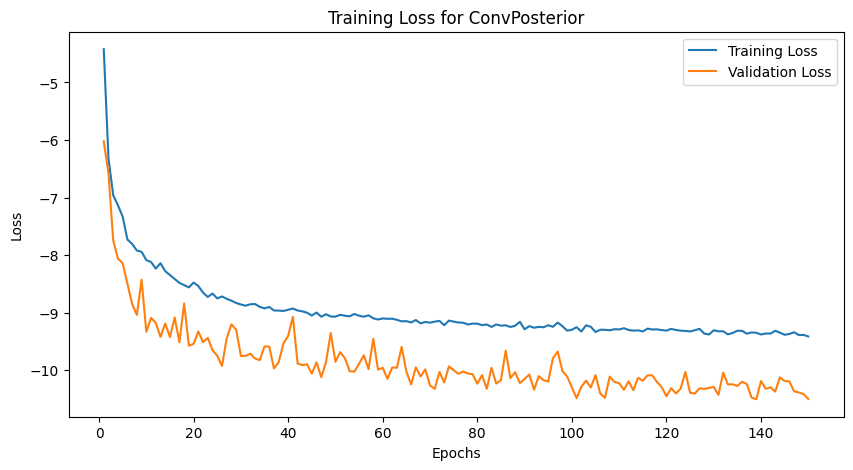

In [28]:
class ConvPosterior(nn.Module):
    """
    A convolutional network to predict the mean and log variance of the model parameters.
    """
    def __init__(self, image_size=16, latent_dim=3, output_dim=6):
        super().__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim
        self.output_dim = output_dim

        # -------------------------
        #   Encoder
        # -------------------------
        # Input shape: [B, 1, 16, 16]
        # Each stride=2 halves W & H => 16 -> 8 -> 4
        self.encoder = nn.Sequential(
            nn.Conv2d(1,  8,  kernel_size=3, stride=2, padding=1),   # -> [B, 16, 8, 8]
            nn.BatchNorm2d(8),
            nn.ReLU(True),

            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),    # -> [B, 8, 4, 4]
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        # Flatten 8×4×4 = 128 -> hidden_dim
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        # x shape: [B, 1, 16, 16]
        x = self.encoder(x)           # -> [B, 8, 4, 4]
        x = x.view(x.size(0), -1)     # flatten to [B, 128]
        x = torch.relu(self.fc1(x))   # -> [B, 128]
        x = self.fc2(x)               # -> [B, output_dim]
        mean = x[:, :self.output_dim//2]
        log_var = x[:, self.output_dim//2:]
        return mean, log_var

# Instantiate the model
posterior_conv_model = ConvPosterior(image_size=image_size, latent_dim=latent_dim, output_dim=6).to(device)

# Loss and optimizer
posterior_optimizer = optim.Adam(posterior_conv_model.parameters(), lr=1e-3)

def negative_log_likelihood(mean, log_var, true_params):
    var = torch.exp(log_var)
    nll = 0.5 * torch.sum(log_var + (true_params - mean)**2 / var, dim=1)
    return torch.mean(nll)

# Training loop
posterior_epochs = 150
posterior_train_losses = []
posterior_valid_losses = []

for epoch in range(1, posterior_epochs + 1):
    posterior_conv_model.train()
    running_train_loss = 0.0
    for (params, input_data) in train_loader:
        params = params.to(device)
        input_data = input_data.to(device)

        # Add observatio noise randomly on the fly
        noise = torch.randn_like(input_data) * sigma_noise
        input_data = input_data + noise

        posterior_optimizer.zero_grad()
        mean, log_var = posterior_conv_model(input_data)

        loss = negative_log_likelihood(mean, log_var, params)
        loss.backward()
        posterior_optimizer.step()

        running_train_loss += loss.item() * params.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    posterior_train_losses.append(epoch_train_loss)

    # Validation
    posterior_conv_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for (params, input_data) in valid_loader:
            params = params.to(device)
            input_data = input_data.to(device)
            mean, log_var = posterior_conv_model(input_data)
            loss = negative_log_likelihood(mean, log_var, params)
            running_val_loss += loss.item() * params.size(0)
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)
    posterior_valid_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch}/{posterior_epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, posterior_epochs + 1), posterior_train_losses, label='Training Loss')
plt.plot(range(1, posterior_epochs + 1), posterior_valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for ConvPosterior')
plt.legend()
plt.show()

<ipython-input-21-9bdacb02762a>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, log_var = posterior_model(torch.tensor(obs_compressed_stat, dtype=torch.float32).to(device))


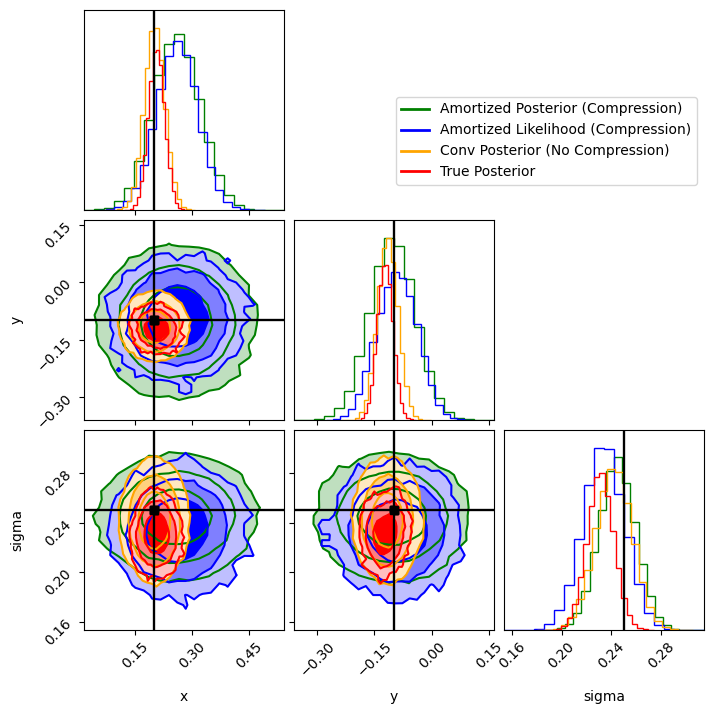

In [ ]:
# Generate samples from the learned posterior neural network
posterior_model.eval()
posterior_conv_model.eval()

with torch.no_grad():
    obs_compressed_stat = compressor_model(obs_image.to(device))
    mean, log_var = posterior_model(torch.tensor(obs_compressed_stat, dtype=torch.float32).to(device))
    var = torch.exp(log_var)
    std = torch.sqrt(var)
    posterior_nn_samples = mean + std * torch.randn(100000, mean.size(1)).to(device)
    posterior_nn_samples = posterior_nn_samples.detach().cpu().numpy()

    mean, log_var = posterior_conv_model(obs_image.to(device))
    var = torch.exp(log_var)
    std = torch.sqrt(var)
    posterior_conv_samples = mean + std * torch.randn(100000, mean.size(1)).to(device)
    posterior_conv_samples = posterior_conv_samples.detach().cpu().numpy()

# Plot the MCMC samples, the posterior neural network samples, and the likelihood + MCMC samples
fig = corner.corner(posterior_nn_samples, labels=["x", "y", "sigma"], truths=true_params, color='green', plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Posterior NN Samples', truth_color='black')
corner.corner(likelihood_nn_samples, labels=["x", "y", "sigma"], truths=true_params, color='blue', fig=fig, plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Likelihood NN + MCMCs', truth_color='black')
corner.corner(posterior_conv_samples, labels=["x", "y", "sigma"], truths=true_params, color='orange', fig=fig, plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Posterior Conv (No Compression)', truth_color='black')
corner.corner(analytic_samples, labels=["x", "y", "sigma"], truths=true_params, color='red', fig=fig, plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='MCMC Samples', truth_color='black')
plt.legend(handles=[plt.Line2D([0], [0], color='green', lw=2, label='Amortized Posterior (Compression)'),
                    plt.Line2D([0], [0], color='blue', lw=2, label='Amortized Likelihood (Compression)'),
                    plt.Line2D([0], [0], color='orange', lw=2, label='Conv Posterior (No Compression)'),
                    plt.Line2D([0], [0], color='red', lw=2, label='True Posterior')],
           loc='upper right', bbox_to_anchor=(1.0, 2.7))
plt.show()

## Further Improvements and Possible Avenues



- **Explore More Flexible Parametric Distributions**: Instead of assuming a Gaussian distribution for the posterior or likelihood, use more expressive models such as normalizing flows, mixture density networks, or other generative models to better capture complex distributions.

- **Implement Active Learning Strategies**: Optimize the number of required simulations by using active learning techniques. This can involve adaptive sampling methods that prioritize generating training data in regions of high uncertainty, improving model efficiency.

- **Enhance Data Compression Techniques**: Improve the way information is compressed by considering more informative representations. For example, incorporate methods that explicitly retain relevant features such as noise statistics, ensuring that crucial uncertainty information is not lost during compression.

- **Experiment with Different Neural Network Architectures**: Investigate alternative deep learning models to improve performance in extracting relevant features for posterior inference.

- **Compare with Alternative Inference Methods**: Benchmark the performance of different simulation-based inference techniques against traditional statistical methods or alternative deep learning approaches.

- **Evaluate Generalization and Robustness**: Study how well the trained models generalize to variations in data distributions, including out-of-distribution samples and different levels of observational noise.